In [6]:
# Gerekli kütüphanelerin import edilmesi
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from sklearn.model_selection import train_test_split
import sys
import plotly.express as px

# ==============================================================================
# 1. GELİŞTİRME ORTAMI VE PROJE AMACI
# ==============================================================================
# Amaç: Bu script, Intel Image Classification veri setini kullanarak 
# bir Evrişimli Sinir Ağı (CNN) modeli oluşturur, eğitir ve değerlendirir.
# Veri seti 6 sınıf içerir: buildings, forest, glacier, mountain, sea, street
# ==============================================================================

# ==============================================================================
# 2. VERİ ÖNİŞLEME VE GÖRSELLEŞTİRME
# ==============================================================================

# --- Veri Yollarını ve Parametreleri Ayarlama ---
# --- Veri Yolu Ayarı ---
# Intel Image Classification veri seti için yol ayarları
# Veri seti yapısı: seg_train/, seg_test/, seg_pred/ klasörleri
# Her klasörde 6 alt klasör: buildings, forest, glacier, mountain, sea, street


In [7]:
TRAIN_DIR = '/kaggle/input/intel-image-classification/seg_train/seg_train'
TEST_DIR = '/kaggle/input/intel-image-classification/seg_test/seg_test'
PRED_DIR = '/kaggle/input/intel-image-classification/seg_pred/seg_pred'
# Veri yolu kontrolü
if not os.path.exists(TRAIN_DIR):
    print(f"HATA: '{TRAIN_DIR}' dizini bulunamadı.")
    print("Lütfen TRAIN_DIR değişkenini doğru veri seti yoluyla güncelleyin.")
    sys.exit() # Dizini bulamazsa scripti durdur

# Model parametreleri
IMG_HEIGHT = 150
IMG_WIDTH = 150
BATCH_SIZE = 32

# Intel Image Classification sınıfları
class_names = ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']
num_classes = len(class_names)

# Veri seti bilgilerini toplama
class_counts = {}
for class_name in class_names:
    class_path = os.path.join(TRAIN_DIR, class_name)
    if os.path.exists(class_path):
        class_counts[class_name] = len(os.listdir(class_path))
    else:
        class_counts[class_name] = 0

print("Sınıf dağılımı:")
for class_name, count in class_counts.items():
    print(f"{class_name}: {count} görsel")

# Plotly ile sınıf dağılımını gösterme
fig = px.pie(names=list(class_counts.keys()), values=list(class_counts.values()), 
             title='Intel Image Classification - Sınıf Dağılımı')
fig.show()

# --- Veri Artırma (Data Augmentation) ve Jeneratörleri Oluşturma ---
train_datagen = ImageDataGenerator(
    rescale=1./255,       # Piksel değerlerini 0-1 arasına ölçekle
    rotation_range=20,    # Rastgele döndürme
    zoom_range=0.2,       # Rastgele yakınlaştırma
    horizontal_flip=True, # Yatay olarak çevirme
    brightness_range=[0.8, 1.2], # Parlaklık ayarı
    validation_split=0.2  # Eğitim verisinin %20'sini doğrulama için ayır
)

# Test verileri için sadece ölçekleme yapıyoruz.
test_datagen = ImageDataGenerator(rescale=1./255)

# --- Veri Akış Jeneratörleri (Data Generators) --- 
# Eğitim jeneratörü (validation_split kullanıyor)
train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',  # Çok sınıflı sınıflandırma için
    subset='training',  # Eğitim kısmı
    classes=class_names  # Sınıf sırasını belirle
)

# Doğrulama jeneratörü
validation_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation',  # Doğrulama kısmı
    classes=class_names
)

# Test jeneratörü (ayrı test klasöründen)
test_generator = test_datagen.flow_from_directory(
    TEST_DIR,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False,  # Değerlendirme için sıranın karışmaması önemli
    classes=class_names
)


Sınıf dağılımı:
buildings: 2191 görsel
forest: 2271 görsel
glacier: 2404 görsel
mountain: 2512 görsel
sea: 2274 görsel
street: 2382 görsel


Found 11230 images belonging to 6 classes.
Found 2804 images belonging to 6 classes.
Found 3000 images belonging to 6 classes.


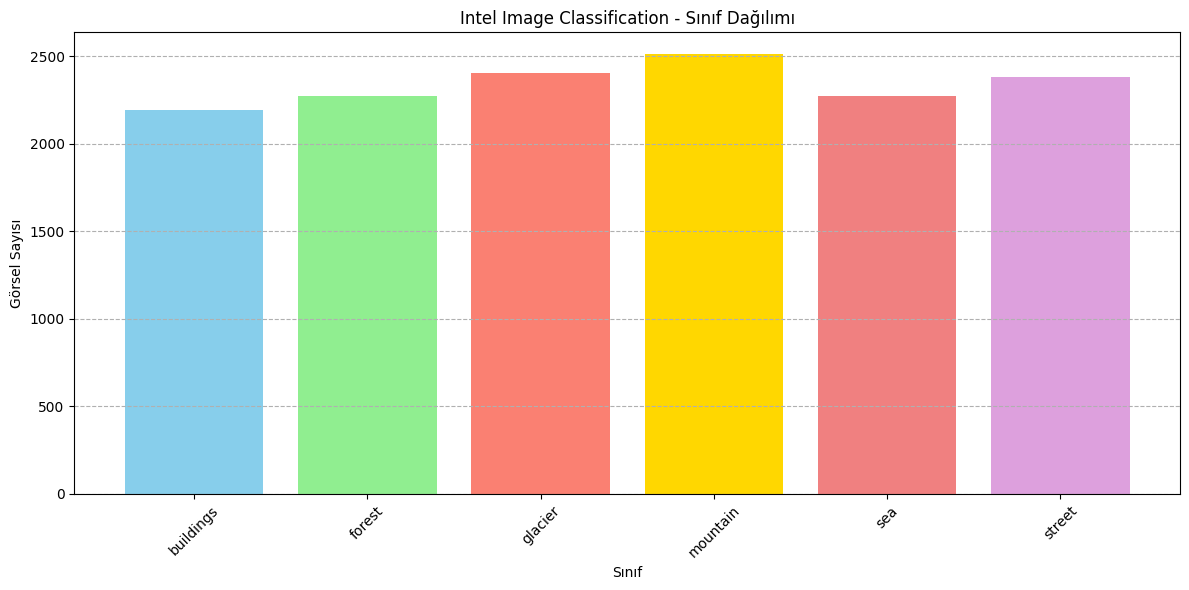

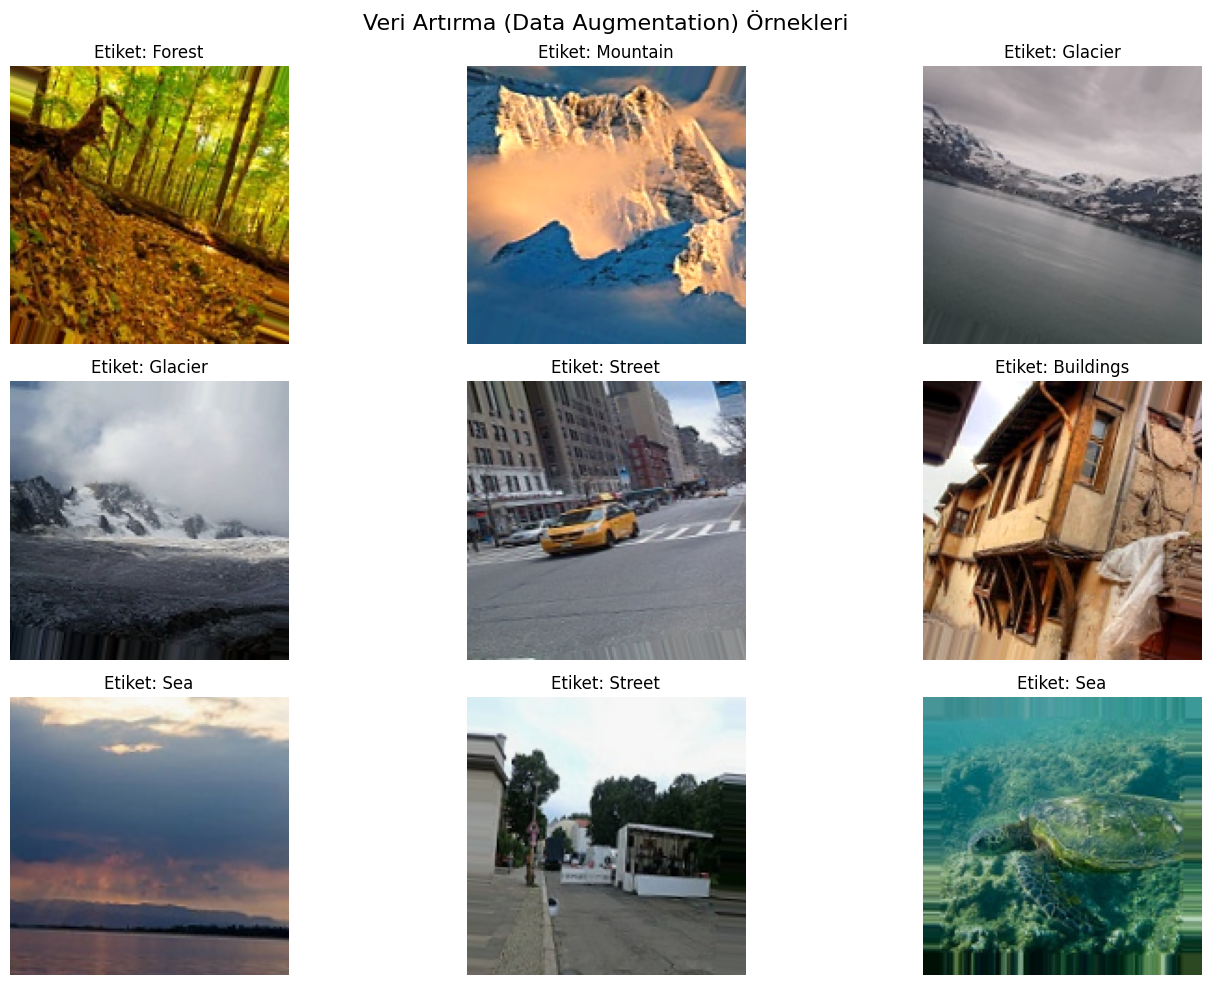

Veri ön işleme ve görselleştirme adımı tamamlandı.
Eğitim seti boyutu: 11230
Doğrulama seti boyutu: 2804
Test seti boyutu: 3000
Sınıf sayısı: 6
Sınıflar: ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']


In [8]:
# --- Görselleştirme ---
# 1. Sınıf Dağılımını Gösterme
plt.figure(figsize=(12, 6))
plt.bar(class_counts.keys(), class_counts.values(), 
        color=['skyblue', 'lightgreen', 'salmon', 'gold', 'lightcoral', 'plum'])
plt.title('Intel Image Classification - Sınıf Dağılımı')
plt.xlabel('Sınıf')
plt.ylabel('Görsel Sayısı')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--')
plt.tight_layout()
plt.show()

# 2. Örnek Görselleri ve Data Augmentation'ı Gösterme
example_images, example_labels = next(train_generator)
plt.figure(figsize=(15, 10))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    image = example_images[i]
    plt.imshow(image)
    # One-hot encoded etiketleri çöz
    label_index = np.argmax(example_labels[i])
    label = class_names[label_index]
    plt.title(f'Etiket: {label.capitalize()}')
    plt.axis('off')
plt.suptitle('Veri Artırma (Data Augmentation) Örnekleri', fontsize=16)
plt.tight_layout()
plt.show()

print("Veri ön işleme ve görselleştirme adımı tamamlandı.")
print(f"Eğitim seti boyutu: {train_generator.samples}")
print(f"Doğrulama seti boyutu: {validation_generator.samples}")
print(f"Test seti boyutu: {test_generator.samples}")
print(f"Sınıf sayısı: {num_classes}")
print(f"Sınıflar: {class_names}")

# ==============================================================================
# 3. MODELİN OLUŞTURULMASI VE EĞİTİLMESİ
# ==============================================================================


In [9]:
# --- CNN Model Mimarisi ---
model = models.Sequential([
    # 1. Konvolüsyon Bloğu
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)),
    layers.MaxPooling2D(2, 2),

    # 2. Konvolüsyon Bloğu
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D(2, 2),

    # 3. Konvolüsyon Bloğu
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D(2, 2),

    # Sınıflandırma Bloğu
    layers.Flatten(),
    layers.Dropout(0.5),  # Aşırı öğrenmeyi önlemek için
    layers.Dense(128, activation='relu'),
    layers.Dense(num_classes, activation='softmax') # Çok sınıflı sınıflandırma için softmax
])

# --- Modeli Derleme ---
model.compile(optimizer='adam',
              loss='categorical_crossentropy',  # Çok sınıflı sınıflandırma için
              metrics=['accuracy'])

# Modelin özetini görüntüleme
model.summary()

# --- Modeli Eğitme ---
# Eğitim süreci, veri setinin büyüklüğüne ve donanımınıza bağlı olarak zaman alabilir.
EPOCHS = 15 # Epoch sayısını denemeler için daha düşük tutabilirsiniz (örn: 10)

history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // BATCH_SIZE
)

print("\nModel eğitimi tamamlandı.")

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 34, 34, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 36992)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 36992)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │     4,735,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 6)              │           774 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,829,126 (18.42 MB)

 Trainable params: 4,829,126 (18.42 MB)

 Non-trainable params: 0 (0.00 B)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning:

Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.



Epoch 1/15
350/350 ━━━━━━━━━━━━━━━━━━━━ 100s 275ms/step - accuracy: 0.4437 - loss: 1.3082 - val_accuracy: 0.7008 - val_loss: 0.8148
Epoch 2/15
  1/350 ━━━━━━━━━━━━━━━━━━━━ 10s 30ms/step - accuracy: 0.7188 - loss: 0.6792

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning:

Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.



350/350 ━━━━━━━━━━━━━━━━━━━━ 18s 52ms/step - accuracy: 0.7188 - loss: 0.6792 - val_accuracy: 0.7044 - val_loss: 0.8057
Epoch 3/15
350/350 ━━━━━━━━━━━━━━━━━━━━ 93s 266ms/step - accuracy: 0.6917 - loss: 0.8127 - val_accuracy: 0.7371 - val_loss: 0.7097
Epoch 4/15
350/350 ━━━━━━━━━━━━━━━━━━━━ 18s 53ms/step - accuracy: 0.7812 - loss: 0.6702 - val_accuracy: 0.7471 - val_loss: 0.7307
Epoch 5/15
350/350 ━━━━━━━━━━━━━━━━━━━━ 92s 264ms/step - accuracy: 0.7324 - loss: 0.7204 - val_accuracy: 0.7812 - val_loss: 0.6214
Epoch 6/15
350/350 ━━━━━━━━━━━━━━━━━━━━ 18s 53ms/step - accuracy: 0.8750 - loss: 0.3680 - val_accuracy: 0.7730 - val_loss: 0.6392
Epoch 7/15
350/350 ━━━━━━━━━━━━━━━━━━━━ 92s 263ms/step - accuracy: 0.7676 - loss: 0.6298 - val_accuracy: 0.7845 - val_loss: 0.5999
Epoch 8/15
350/350 ━━━━━━━━━━━━━━━━━━━━ 19s 54ms/step - accuracy: 0.8125 - loss: 0.5756 - val_accuracy: 0.7945 - val_loss: 0.5817
Epoch 9/15
350/350 ━━━━━━━━━━━━━━━━━━━━ 94s 269ms/step - accuracy: 0.7831 - loss: 0.5892 - val_acc

# ==============================================================================
# 4. MODELİN DEĞERLENDİRİLMESİ
# ==============================================================================

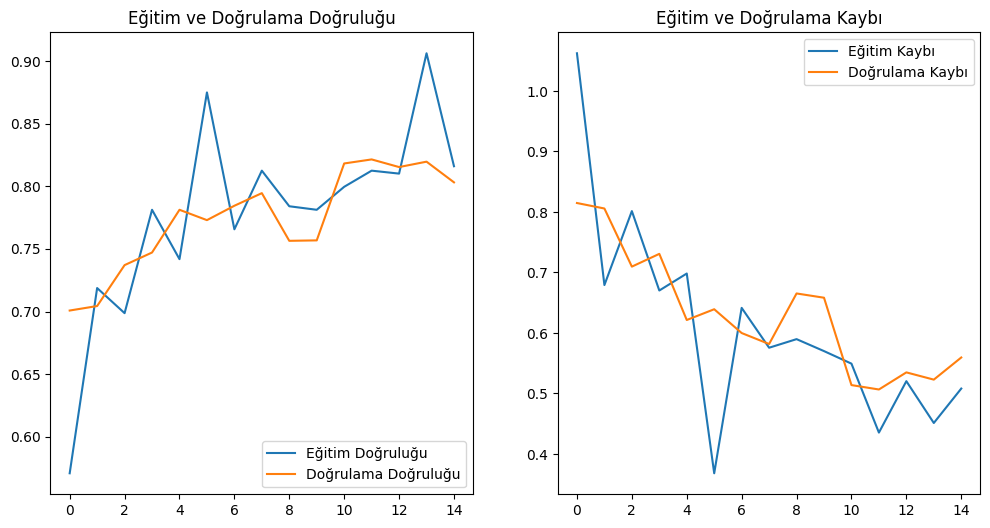


Test seti üzerinde değerlendirme yapılıyor...
94/94 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.7744 - loss: 0.5903
Test Doğruluğu: 0.7993
94/94 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step


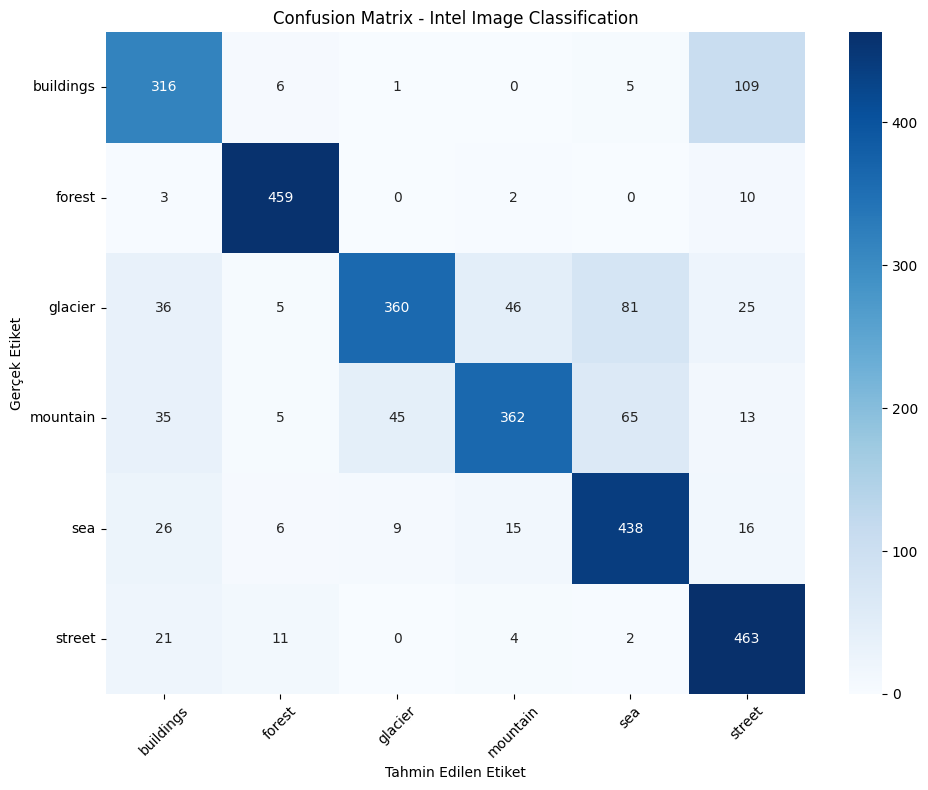


Sınıflandırma Raporu:
              precision    recall  f1-score   support

   buildings       0.72      0.72      0.72       437
      forest       0.93      0.97      0.95       474
     glacier       0.87      0.65      0.74       553
    mountain       0.84      0.69      0.76       525
         sea       0.74      0.86      0.80       510
      street       0.73      0.92      0.81       501

    accuracy                           0.80      3000
   macro avg       0.81      0.80      0.80      3000
weighted avg       0.81      0.80      0.80      3000



In [10]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# --- Eğitim ve Doğrulama Grafikleri ---
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Eğitim Doğruluğu')
plt.plot(epochs_range, val_acc, label='Doğrulama Doğruluğu')
plt.legend(loc='lower right')
plt.title('Eğitim ve Doğrulama Doğruluğu')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Eğitim Kaybı')
plt.plot(epochs_range, val_loss, label='Doğrulama Kaybı')
plt.legend(loc='upper right')
plt.title('Eğitim ve Doğrulama Kaybı')
plt.show()

# --- Test Seti ile Değerlendirme ---
print("\nTest seti üzerinde değerlendirme yapılıyor...")
# Tüm test setini değerlendirdiğimizden emin olalım
steps_for_eval = -(-test_generator.samples // BATCH_SIZE) # Ceiling division
test_loss, test_acc = model.evaluate(test_generator, steps=steps_for_eval)
print(f'Test Doğruluğu: {test_acc:.4f}')

# --- Confusion Matrix ve Sınıflandırma Raporu ---
# Tahminleri yap
y_pred_prob = model.predict(test_generator, steps=steps_for_eval)

# Gerçek etiketleri ve tahmin edilen etiketleri al
# Çok sınıflı sınıflandırma için one-hot encoded etiketleri çöz
y_true = test_generator.classes
y_pred = np.argmax(y_pred_prob, axis=1)[:len(y_true)]

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix - Intel Image Classification')
plt.ylabel('Gerçek Etiket')
plt.xlabel('Tahmin Edilen Etiket')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# Sınıflandırma Raporu
print('\nSınıflandırma Raporu:')
print(classification_report(y_true, y_pred, target_names=class_names))

# ==============================================================================
# 5. HİPERPARAMETRE OPTİMİZASYONU
# ==============================================================================

In [11]:
print("\n--- Hiperparametre Optimizasyonu Başlatılıyor ---")

# --- Denenecek Parametreler ---
param_grid = {
    'batch_size': [32, 64],
    'learning_rate': [0.001, 0.0001],
    'dropout': [0.3, 0.5]
}

results = []

# --- Model Oluşturma ve Derleme Fonksiyonu ---
def create_model(dropout_rate, learning_rate):
    model = models.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)),
        layers.MaxPooling2D(2, 2),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D(2, 2),
        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.MaxPooling2D(2, 2),
        layers.Flatten(),
        layers.Dropout(dropout_rate), # Değişken dropout oranı
        layers.Dense(128, activation='relu'),
        layers.Dense(num_classes, activation='softmax')
    ])
    
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate) # Değişken öğrenme oranı
    
    model.compile(optimizer=optimizer,
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

# --- Optimizasyon Döngüsü ---
for batch_size in param_grid['batch_size']:
    for lr in param_grid['learning_rate']:
        for dropout in param_grid['dropout']:
            print(f"\n--- Deneme: Batch Size={batch_size}, LR={lr}, Dropout={dropout} ---")

            # Yeni batch size için jeneratörleri yeniden oluştur
            train_datagen_hp = ImageDataGenerator(
                rescale=1./255, rotation_range=20, zoom_range=0.2,
                horizontal_flip=True, brightness_range=[0.8, 1.2],
                validation_split=0.2
            )
            
            train_generator_hp = train_datagen_hp.flow_from_directory(
                TRAIN_DIR, target_size=(IMG_HEIGHT, IMG_WIDTH),
                batch_size=batch_size, class_mode='categorical',
                subset='training', classes=class_names
            )
            validation_generator_hp = train_datagen_hp.flow_from_directory(
                TRAIN_DIR, target_size=(IMG_HEIGHT, IMG_WIDTH),
                batch_size=batch_size, class_mode='categorical',
                subset='validation', classes=class_names
            )

            # Modeli oluştur ve eğit
            model_hp = create_model(dropout_rate=dropout, learning_rate=lr)
            
            # Optimizasyon için epoch sayısını daha düşük tutabiliriz (örn: 5)
            history_hp = model_hp.fit(
                train_generator_hp,
                epochs=5, 
                validation_data=validation_generator_hp,
                verbose=0 # Çıktıyı daha temiz tutmak için
            )

            # Sonuçları kaydet
            val_accuracy = history_hp.history['val_accuracy'][-1]
            val_loss = history_hp.history['val_loss'][-1]
            results.append({
                'batch_size': batch_size,
                'learning_rate': lr,
                'dropout': dropout,
                'val_accuracy': val_accuracy,
                'val_loss': val_loss
            })
            print(f"Sonuç: Val Accuracy = {val_accuracy:.4f}, Val Loss = {val_loss:.4f}")

# --- Sonuçları Tablo Halinde Gösterme ---
results_df = pd.DataFrame(results)
results_df = results_df.sort_values(by='val_accuracy', ascending=False)

print("\n--- Hiperparametre Optimizasyon Sonuçları ---")
print(results_df)

print("\nProje tamamlandı!")


--- Hiperparametre Optimizasyonu Başlatılıyor ---

--- Deneme: Batch Size=32, LR=0.001, Dropout=0.3 ---
Found 11230 images belonging to 6 classes.
Found 2804 images belonging to 6 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning:

Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.



Sonuç: Val Accuracy = 0.7885, Val Loss = 0.5739

--- Deneme: Batch Size=32, LR=0.001, Dropout=0.5 ---
Found 11230 images belonging to 6 classes.
Found 2804 images belonging to 6 classes.
Sonuç: Val Accuracy = 0.7846, Val Loss = 0.6010

--- Deneme: Batch Size=32, LR=0.0001, Dropout=0.3 ---
Found 11230 images belonging to 6 classes.
Found 2804 images belonging to 6 classes.
Sonuç: Val Accuracy = 0.7507, Val Loss = 0.6964

--- Deneme: Batch Size=32, LR=0.0001, Dropout=0.5 ---
Found 11230 images belonging to 6 classes.
Found 2804 images belonging to 6 classes.
Sonuç: Val Accuracy = 0.7443, Val Loss = 0.7214

--- Deneme: Batch Size=64, LR=0.001, Dropout=0.3 ---
Found 11230 images belonging to 6 classes.
Found 2804 images belonging to 6 classes.
Sonuç: Val Accuracy = 0.7892, Val Loss = 0.5789

--- Deneme: Batch Size=64, LR=0.001, Dropout=0.5 ---
Found 11230 images belonging to 6 classes.
Found 2804 images belonging to 6 classes.
Sonuç: Val Accuracy = 0.8046, Val Loss = 0.5698

--- Deneme: Ba